# SUMMA Turbulence Scheme Conversion
### Testing of offline turbulence against Snoqualmie observations

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xr
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

import turbpy

In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

# Apply to Snoqualmie Observations

## Read Snoqualmie Obs

In [3]:
## Read the formatted supporting snoqualmie obs
os.chdir(dirData)
support = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

In [4]:
## Met variables
mHeight = 6.
scalarGroundSnowFraction  = 1.
soilRelHumidity = 1.

# Turbulence parameters
z0Ground = .005

## Misc. variables
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')

## Discriminate for only wind > 2ms-1

In [5]:
## Select only turbulence data that meets the assumptions for eddy-covariance
ind = np.nonzero ( (support.SP == 1).values &\
                  (support.WIND > 2).values & \
                  (~(np.isnan(support.SensFlux)).values |\
                  ~(np.isnan(support.LatFlux)).values)
                  )
snoqTurbObs = xr.Dataset({'sensible' : (['time'], support.SensFlux[ind].values),
                          'latent' : (['time'], support.LatFlux[ind].values)},
                         coords={'time': support.time[ind]})

In [6]:
offLineCalcFlag = False  # Flag that toggles offline simulation, if False loads previous simulation results
if offLineCalcFlag: 
    sensible = xr.Dataset()
    sensible.coords['time'] = support.time[ind]
    latent = xr.Dataset()
    latent.coords['time'] = support.time[ind]

    for stab in ixStability:
        senHeatGround = np.ones(support.time[ind].size)*np.nan # sensible heat flux from ground surface (W m-2)
        latHeatGround = np.ones(support.time[ind].size)*np.nan # latent heat flux from ground surface (W m-2)

        # Loop over each time step with snow
        for n,d in enumerate(support.time[ind]):
            # Met data at Snoqualmie on the given date
            ds = support.sel(time=d)
            snowDepth = ds.Snowdepth  # (m)
            airVaporPress = ds.Vap_press_6  * 1000  # (kPa) -> (Pa)
            airTemp = ds.T6+273.15  # (C) -> (K)
            sfcTemp = ds.Tsrf+273.15  # (C) -> (K)
            sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
            windspd = ds.WIND  # (m/s)

            if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
                continue
            else:
                # Offline turbulence
                (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
                    airTemp, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                    groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                    )

        sensible[stab] = (('time'),senHeatGround)
        latent[stab] = (('time'),latHeatGround)

    ########
    # Save sensible/latent offline
    sensible.to_netcdf('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
    latent.to_netcdf('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

else:
    sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
    latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

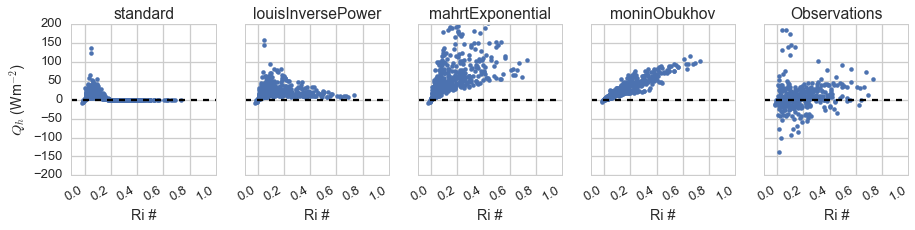

In [7]:
########
# Sensible
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(15,3))
Qmax = 200
Qmin = -200
RiMax = 1.
RiMin = -0.1

Ri = turbpy.bulkRichardson(support.T6[ind] + 273.15,
                           support.Tsrf[ind] + 273.15,
                           support.WIND[ind], 
                           mHeight-support.Snowdepth[ind],
                           False)

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], sensible[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.SensFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

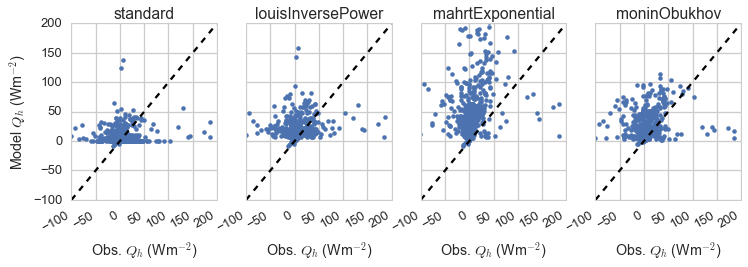

In [8]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3.5))
Qmax = 200
Qmin = -100

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(support.SensFlux[ind], sensible[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

## Use all turbulence data when snow is present

In [9]:
## Select only turbulence data that meets the assumptions for eddy-covariance
ind = np.nonzero ((support.SP == 1).values &
                  (~(np.isnan(support.SensFlux)).values |
                   ~(np.isnan(support.LatFlux)).values))
snoqTurbObs = xr.Dataset({'sensible' : (['time'], support.SensFlux[ind].values),
                          'latent' : (['time'], support.LatFlux[ind].values)},
                         coords={'time': support.time[ind]})

In [10]:
if offLineCalcFlag:
    sensible = xr.Dataset()
    sensible.coords['time'] = support.time[ind]
    latent = xr.Dataset()
    latent.coords['time'] = support.time[ind]

    for stab in ixStability:
        senHeatGround = np.ones(support.time[ind].size)*np.nan       # sensible heat flux from ground surface (W m-2)
        latHeatGround = np.ones(support.time[ind].size)*np.nan       # latent heat flux from ground surface (W m-2)

        # Loop over each time step with snow
        for n,d in enumerate(support.time[ind]):        
            # Met data at Snoqualmie on the given date
            ds = support.sel(time=d)
            snowDepth = ds.Snowdepth  # (m)
            airVaporPress = ds.Vap_press_6  * 1000  # (kPa) -> (Pa)
            airTemp = ds.T6+273.15  # (C) -> (K)
            sfcTemp = ds.Tsrf+273.15  # (C) -> (K)
            sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
            windspd = ds.WIND  # (m/s)

            if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
                continue
            else:
                # Offline turbulence
                (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
                    airTemp, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                    groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                    )

        sensible[stab] = (('time'),senHeatGround)
        latent[stab] = (('time'),latHeatGround)
        
    ########
    # Save sensible/latent offline
    sensible.to_netcdf('TF.SNQ_SP.OfflineTurb.sensible.nc')
    latent.to_netcdf('TF.SNQ_SP.OfflineTurb.latent.nc')

# Load previously calculated simulation results
else:
    sensibleAll = xr.open_dataset('TF.SNQ_SP.OfflineTurb.sensible.nc')
    latentAll = xr.open_dataset('TF.SNQ_SP.OfflineTurb.latent.nc')

ValueError: x and y must have same first dimension

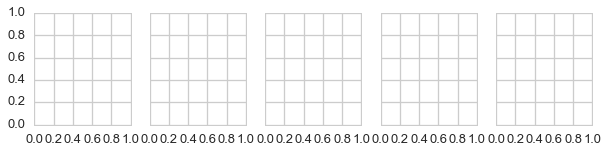

In [11]:
########
# Sensible
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(10,2))
Qmax = 200
Qmin = -200
RiMax = 1.
RiMin = -0.1

Ri = turbpy.bulkRichardson(support.T6[ind]+273.15,
                           support.Tsrf[ind]+273.15,
                           support.WIND[ind], 
                           mHeight - support.Snowdepth[ind],
                           False)

for n, stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], sensibleAll[stab], '.', label=stab)
    ax.plot([RiMin, RiMax], [0, 0], 'k--')
    ax.set_xlim(RiMin, RiMax)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.SensFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

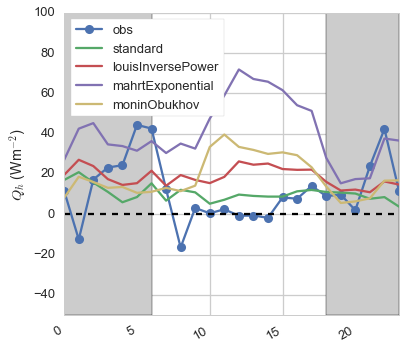

In [22]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,ax = plt.subplots(1, 1, sharey=True, figsize=(6, 6))
Qmax = 100
Qmin = -50

ind = np.nonzero ((support.SP == 1).values &
                  (support.WIND > 2).values &
                  (~(np.isnan(support.SensFlux)).values |
                   ~(np.isnan(support.LatFlux)).values))

ax.plot(np.arange(0, 24),
        support.SensFlux[ind].groupby('time.hour').mean(dim='time'), '-o',
        label='obs')
ax.plot([0, 23], [0, 0], 'k--')
ax.fill_between(np.arange(0, 7), Qmin, Qmax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), Qmin, Qmax, facecolor='0.8')
for n,stab in enumerate(ixStability):
    ax.plot(np.arange(0, 24),
            sensible[stab].groupby('time.hour').mean(dim='time'),
            label=stab)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlim(0, 23)
    ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')
ax.legend(loc='best', frameon=True)
fig.autofmt_xdate()

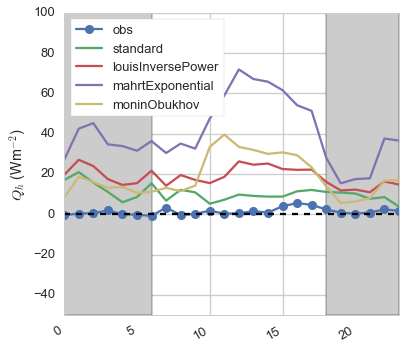

In [21]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,ax = plt.subplots(1, 1, sharey=True, figsize=(6, 6))
Qmax = 100
Qmin = -50

ind = np.nonzero ((support.SP == 1).values &
                  (~(np.isnan(support.SensFlux)).values |
                   ~(np.isnan(support.LatFlux)).values))

ax.plot(np.arange(0, 24),
        support.SensFlux[ind].groupby('time.hour').mean(dim='time'), '-o',
        label='obs')
ax.plot([0, 23], [0, 0], 'k--')
ax.fill_between(np.arange(0, 7), Qmin, Qmax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), Qmin, Qmax, facecolor='0.8')
for n,stab in enumerate(ixStability):
    ax.plot(np.arange(0, 24),
            sensible[stab].groupby('time.hour').mean(dim='time'),
            label=stab)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlim(0, 23)
    ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')
ax.legend(loc='best', frameon=True)
fig.autofmt_xdate()